In [278]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from ipcv import cvlib
from importlib import reload
from scipy import stats as st

reload(cvlib)

<module 'ipcv.cvlib' from '/Users/everhett/Projects/python-ws/qr-scanner/ipcv/cvlib.py'>

In [279]:
# A function to display side-by-side visuals for comparisons and swaps previous and current data for continues processing.
def display_and_swap(data, curr_img, curr_label, display=True):
    # Display the previous and current side-by-side for visual comparison.
    if display:
        plt.figure(figsize=(14, 12))
        plt.subplot(1, 2, 1)
        plt.imshow(data['prev'], cmap='gray')
        plt.title(data['prev_label'])

        plt.subplot(1, 2, 2)
        plt.imshow(curr_img, cmap='gray')
        plt.title(curr_label)

    # Swap data for subsequent execution.
    data['prev'] = curr_img
    data['prev_label'] = curr_label

    data['curr'] = None
    data['curr_label'] = None

    return data

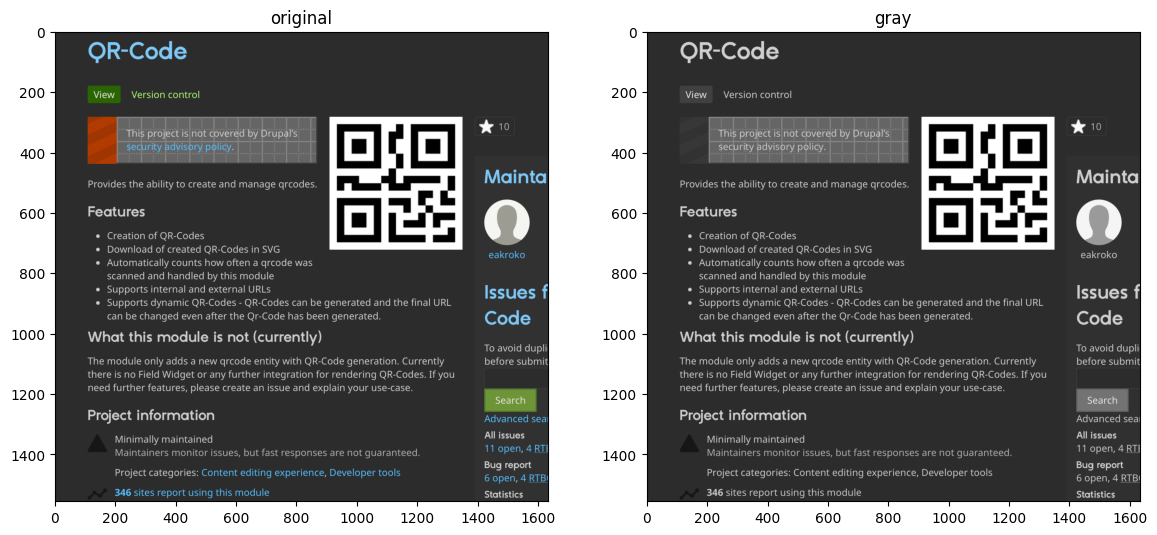

In [280]:
# Load the image as RGB.
# image = cvlib.load_image('resources/qr-code/qrcode201.jpeg')
image = cvlib.load_image('resources/qr-code/qrcode100.png')

# Convert the image into gray for processing.
label = 'gray'
curr = cvlib.convert_rgb2gray(image)

# Manually set the data once. The swap_and_display() will take care of this data for subsequent operations.
dat = {}
dat = {'prev': image, 'prev_label': 'original', 'curr': curr, 'curr_label': label}

# The current data is replaced to previous for next operation.
dat = display_and_swap(dat, curr, label)

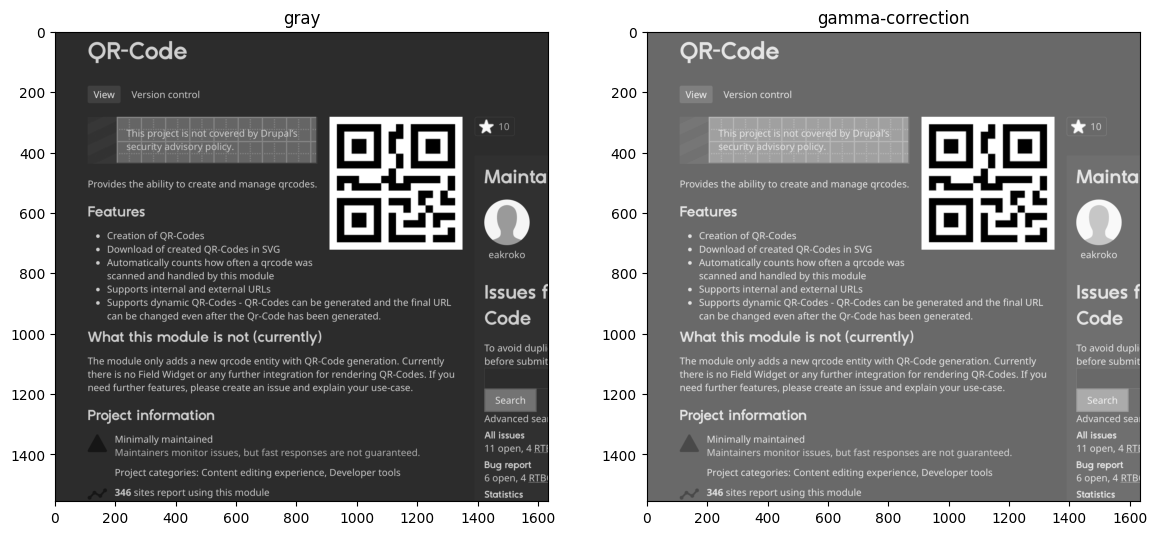

In [281]:
# Correct image's contrast before removing noises.
label = 'gamma-correction'
gamma = 0.5

curr = cvlib.adjust_gamma(dat['prev'], gamma)
# curr = cvlib.adjust_gamma3(dat['prev'], gamma)

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

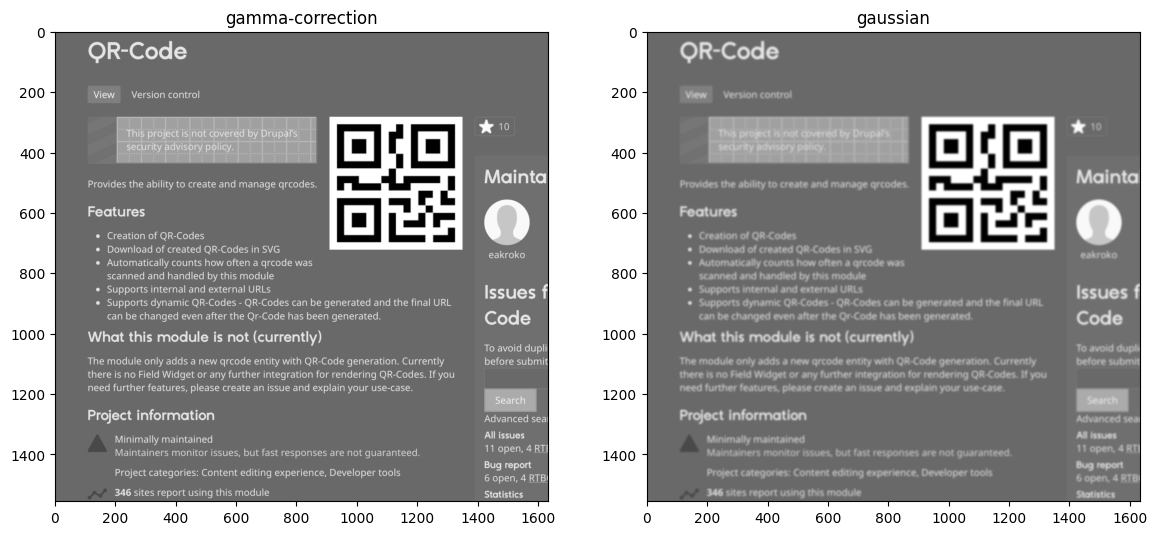

In [282]:
# Gaussian blur to removes noise before processing.
label = 'gaussian'
ksize = (15, 15)
sigma = 0
curr = cvlib.gaussian_blur(dat['prev'], ksize, sigma)

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

In [283]:
# # Average blur
# label = 'avg blur'
# kernel = [9, 9]
# curr = cvlib.average_blur(dat['prev'], kernel)
#
# # Display and swap for data for next operation.
# dat = display_and_swap(dat, curr, label)

In [284]:
# # Detect edges for processing.
# label = 'edges'
# curr = cvlib.detect_gradient(dat['prev'])
#
# # Display and swap for data for next operation.
# dat = display_and_swap(dat, curr, label)

In [285]:
# # Average blur
# label = 'avg blur'
# kernel = [3, 3]
# curr = cvlib.average_blur(dat['prev'], kernel)
#
# # Display and swap for data for next operation.
# dat = display_and_swap(dat, curr, label)

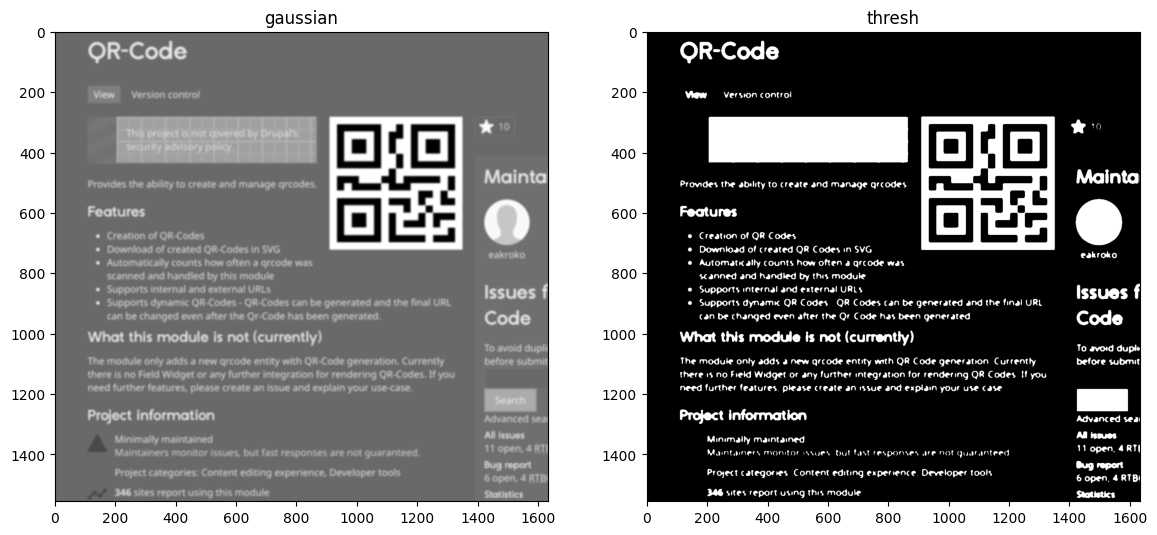

In [286]:
label = 'thresh'
thresh = 200
# curr = cvlib.binarize(dat['prev'], thresh)
curr = cv2.threshold(dat['prev'], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

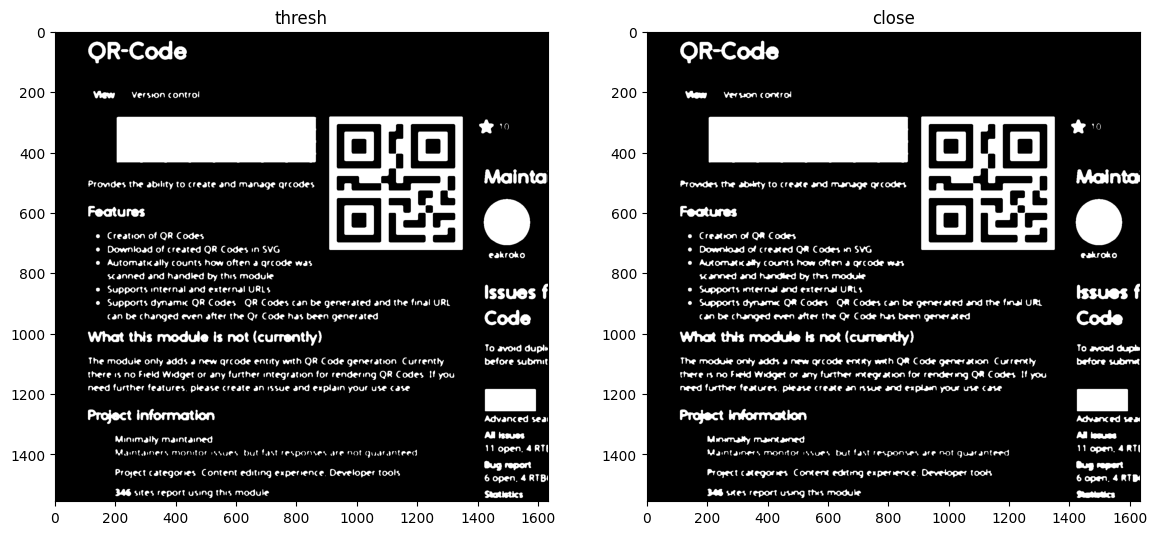

In [287]:
label = 'close'
dilate_kernel = (5, 5)
curr = cvlib.morph_close(dat['prev'], dilate_kernel)

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

In [288]:
# label = 'dilate'
# dilate_iteration = 2
# curr = cvlib.morph_dilate(dat['prev'], dilate_iteration)
#
# # Display and swap for data for next operation.
# dat = display_and_swap(dat, curr, label)

In [289]:
# label = 'shrink'
# x = dat['prev']
# new_width = int(x.shape[1] / 2)
# new_height = int(x.shape[0] / 2)
#
# curr = cvlib.resize_image(dat['prev'], new_width, new_height)
# dat = display_and_swap(dat, curr, label)

In [290]:
# label = 'enlarge'
#
# curr = cvlib.resize_image(dat['prev'], x.shape[1], x.shape[0])
# dat = display_and_swap(dat, curr, label)

In [293]:
contours, _ = cv2.findContours(dat['prev'], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [294]:
cropped = None
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    if len(approx) == 4:
        area = cv2.contourArea(contour)
        (x, y, w, h) = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)

        if area > 100 and 0.8 <= aspect_ratio <= 1.2:
            cv2.drawContours(image, [approx], -1, (0, 255, 0), 3)

            cropped = image[y:y + h, x:x + w]
            print('Found!!!!!')
        print('Found == 4')
    else:
        print('No contour found')


No contour found
No contour found
No contour found
Found == 4
No contour found
No contour found
No contour found
Found == 4
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
Found == 4
No contour found
No contour found
Found == 4
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
Found == 4
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
Found == 4
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found
No contour found

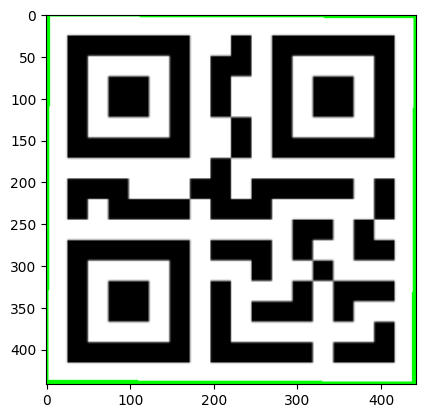

In [295]:
plt.imshow(cropped, cmap='gray')

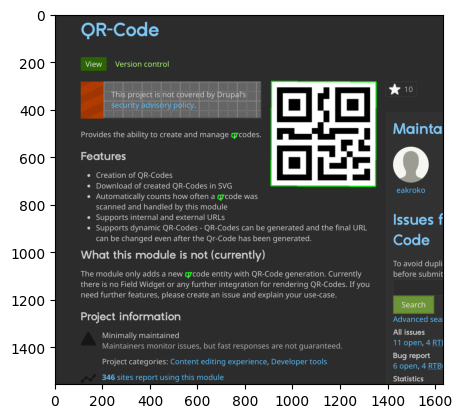

In [296]:
plt.imshow(image)